In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
if not os.path.exists('data'):
    os.mkdir('data')

In [64]:
df = pd.read_csv('data/cleaned_data.csv')

In [66]:
df.head()

,YEAR,AGECAT,SEX,EMPLOY18,HEALTH,MENTHLTH,PRLMISEVR,PRLMISAB,PRLANY,HEROINEVR,HEROINUSE,TRQLZRS,SEDATVS,COCAINE,AMPHETMN,HALUCNG,TRTMENT,MHTRTMT
0,15,3,1,2,3,4,1,10,10,1,5,5,0,5,2,2,6,0
1,15,3,0,1,6,7,1,10,10,1,5,5,0,4,3,5,5,0
2,15,2,0,3,4,2,1,10,9,1,5,5,0,4,2,3,7,2
3,15,1,0,3,5,0,1,10,9,1,5,5,0,3,2,2,0,0
4,15,5,0,3,5,2,1,9,9,1,5,5,3,2,2,2,7,0


In [68]:
df.shape

(303317, 18)

In [70]:
df['PRLMISEVR'].value_counts()

PRLMISEVR
0    152080
1    151237
Name: count, dtype: int64

In [74]:
X = df.drop(columns=['PRLMISAB', 'PRLMISEVR', 'PRLANY'])
y = df['PRLMISEVR']

# PCA/Multiple Classification Models

In [49]:
rf = RandomForestClassifier(n_estimators=600, max_features=9, max_depth=30)
pc = PCA(n_components=6)
logr = LogisticRegression(max_iter=10000, penalty=None)
nb = MultinomialNB()

tts = train_test_split(X, y, random_state=42)

pipes = [
    Pipeline([('pca', pc), ('rf', rf)]),
    Pipeline([('pca', pc), ('logr', logr)]),
    Pipeline([('logr', logr)]),
    Pipeline([('nb', nb)])
]

In [51]:
def eval_pipe(pipe, tts, lbl):
    X_train, X_test, y_train, y_test = tts
    pipe.fit(X_train, y_train)
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    print('='*40)
    print(f'Pipeline #{i}:')
    print(f'Train Acc = {100*train_score:,.2f}% :: Test Acc = {100*test_score:,.2f}%')

In [53]:
for i, pipe in enumerate(pipes):
    eval_pipe(pipe, tts, i)

Pipeline #0:
Train Acc = 85.92% :: Test Acc = 83.35%
Pipeline #1:
Train Acc = 73.99% :: Test Acc = 74.20%
Pipeline #2:
Train Acc = 73.99% :: Test Acc = 74.19%
Pipeline #3:
Train Acc = 73.57% :: Test Acc = 73.80%


# Determining Importance

In [19]:
pc = PCA()
pc.fit(X)

PCA()

In [21]:
Z = pc.transform(X)

In [23]:
Z.shape

(303317, 15)

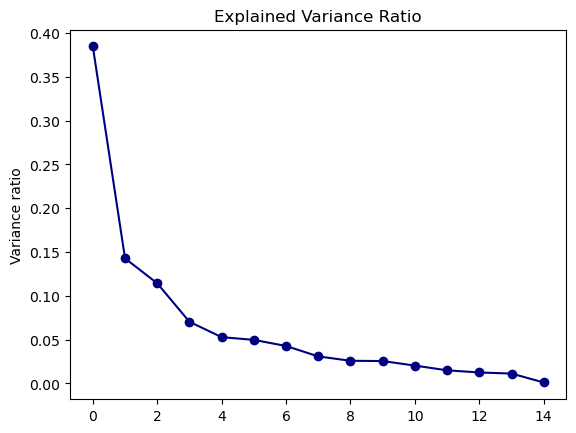

In [94]:
plt.plot(pc.explained_variance_ratio_, c='navy')
plt.scatter(np.arange(15), pc.explained_variance_ratio_, c='navy')
plt.title('Explained Variance Ratio')
plt.ylabel('Variance ratio');
plt.savefig('var_ratio.png', dpi=192)

In [35]:
V = pc.components_
importance = np.round(np.abs(V[0, :]) / np.sum(np.abs(V[0, :])), 3)
imp_chart = pd.DataFrame({
    'vars': X.columns,
    'importances': importance
}).sort_values('importances', ascending=False)

In [37]:
imp_chart.head()

,vars,importances
5,MENTHLTH,0.422
12,HALUCNG,0.091
14,MHTRTMT,0.077
8,TRQLZRS,0.075
4,HEALTH,0.060


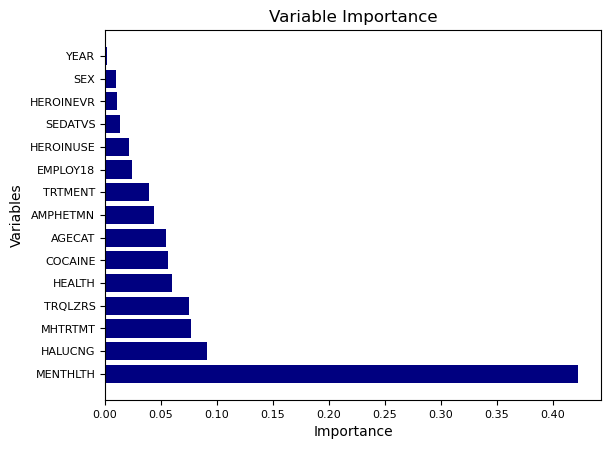

In [77]:
plt.barh(imp_chart['vars'], imp_chart['importances'], color='navy')
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.yticks(size=8)
plt.xticks(size=8);
plt.savefig('var_imp.png', dpi=192)

# Neural Net Model

In [76]:
X_nn = df.drop(columns=['PRLMISAB', 'PRLMISEVR', 'PRLANY'])
y_nn = df['PRLMISEVR']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, random_state=42)

In [13]:
X_train.shape

(227487, 15)

In [15]:
y_train.shape

(227487,)

In [17]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(15, ), kernel_regularizer = l2(0.001)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,801 (128.13 KB)

 Trainable params: 32,801 (128.13 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(loss='bce', optimizer='adam', metrics=['acc'])

In [21]:
%%time
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=0,
    epochs=100
)

CPU times: user 26min 19s, sys: 3min 21s, total: 29min 40s
Wall time: 16min 33s


In [29]:
model.evaluate(X_test, y_test)

2370/2370 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - acc: 0.7546 - loss: 0.5353


[0.5360209345817566, 0.7534353137016296]

In [31]:
model.evaluate(X_train, y_train)

7109/7109 ━━━━━━━━━━━━━━━━━━━━ 5s 674us/step - acc: 0.7510 - loss: 0.5374


[0.5381205081939697, 0.7502714395523071]

In [79]:
y_hat = model.predict(X_test)

2370/2370 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


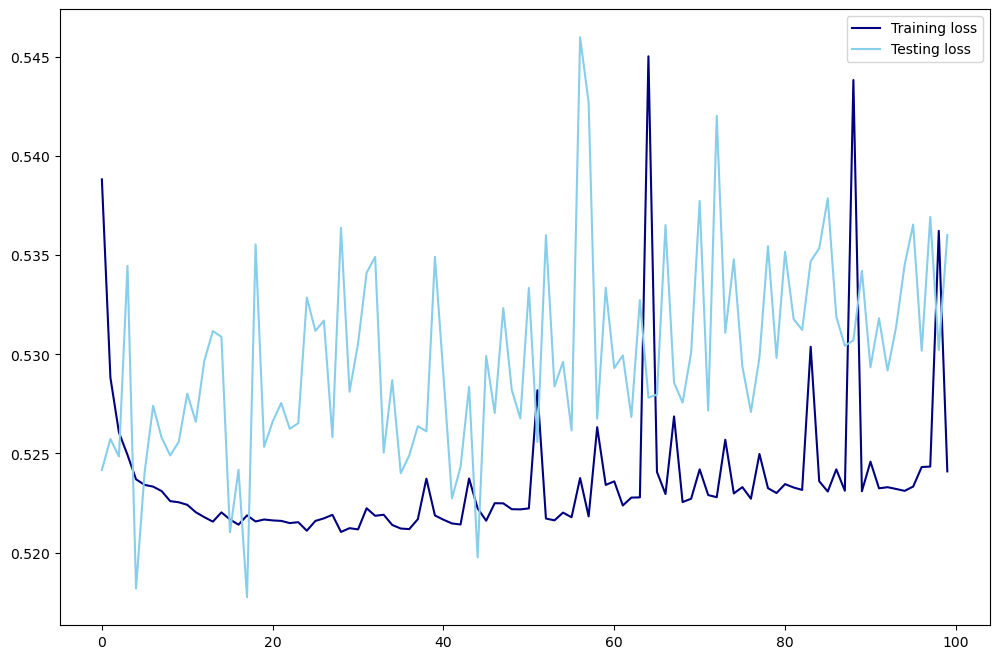

In [33]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

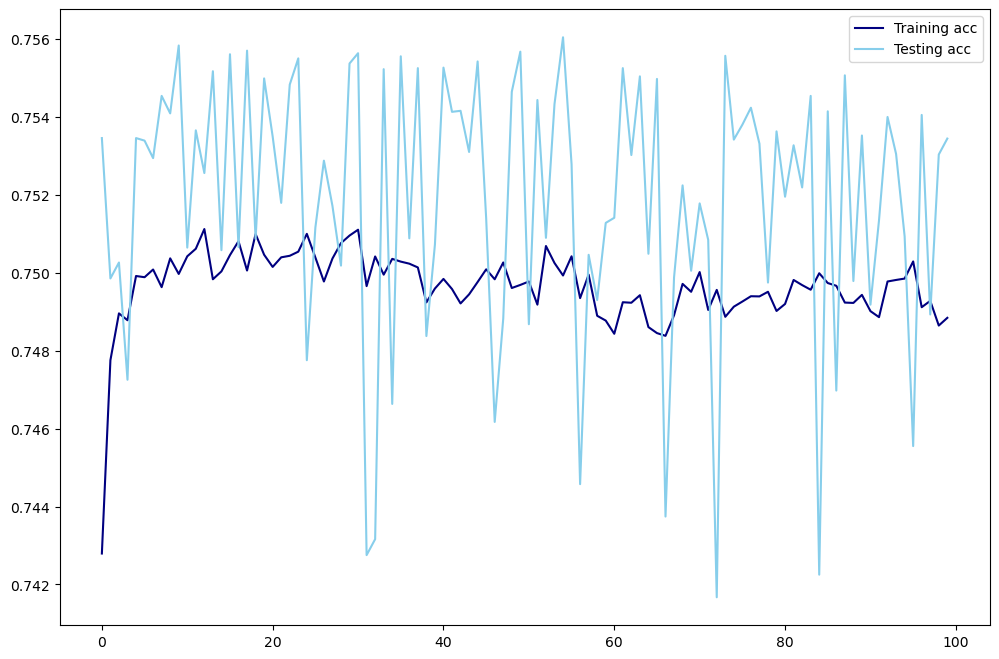

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['acc'], label='Training acc', color='navy')
plt.plot(history.history['val_acc'], label='Testing acc', color='skyblue')
plt.legend();